## Back to Evil Kneevel - Numerical Solutions to the Trajectory Problem

Let's load the standard packages, as well as our own ODE set of routines. Those are vectorized version of the algorithms we developed last time, and we put them into ode.py - please take a look at those. They have some added functionality to pass parameters to the functions which evaluate the time derivative.

In [1]:
#%pip install -q ipywidgets matplotlib numpy scipy pandas 
#install packages used by this tutorial.
import numpy  as np
import pandas as pd
import ode    as odeLib        # our self-defined ODE routines in ode.py.
import matplotlib.pyplot as plt


The ODE functions expect a parameter variable that holds other variables, what in C is called a *structure*. We can use it like so:

In [2]:
from dataclasses import dataclass,astuple,asdict # for C-like structure

and then we can define what sorts of parameters or other variables we want to be contained in the structure. For the Evil Kneevel problem, the system is defined by the drag coefficient $c$ and the gravitational acceleration $g$ - speed and angle enter as initial conditions, so we do not have to worry about those. 

In [3]:
@dataclass
class parameters:                 # parameters for functions, default values
    c : float  = 0 # drag
    g : float = 9.81 # graviational acc.
    

And now, we can declare a single structure

In [4]:
par=parameters()

where par is now initialized with the default values.

In [5]:
print(par)

parameters(c=0, g=9.81)


In general, this allows us to keep things neat, and pass only one variable to a function, a structure, that can hold arbitrary numbers of other variables.

Now, here is our function to fill in the right hand side of the time evolution equation, the time derivatives for everything that changes in time, here $\{x,y,v_x,v_y\}$. Recall that Python orders arrays $0,1,\ldots N-1$.

In [6]:
def f0(t, x, par):
    # time evolution of x y v_x v_y, expects a 4-D vector
    # first derivative
    return x[2] # v_x
def f1(t, x, par): # second derivative
    return x[3] # v_y
def f2(t, x, par):
    vamp = np.sqrt(x[2]**2+x[3]**2)
    return -par.c*vamp*x[2]
def f3(t, x, par):
    vamp = np.sqrt(x[2]**2+x[3]**2)
    return -par.g - par.c*vamp*x[3]
# let's pack it up
f     = [f0, f1, f2, f3]
ndim = 4

This function takes the time $t$, the *state vector* ${\bf x}$, and a parameter structure and returns the derivative, see our last exercise. Now, let's see how this works for zero drag, the simple case, for which we know there is an analytical solution.

In [7]:
par=parameters()
par.c=0 # make sure drag is zero, later  change 
# initial conditions for x y v_x v_y
theta=5/180*np.pi
s=1 # initial speed
vx0, vy0 = np.sin(theta)*s, np.cos(theta)*s
y = [ 0 , 0,  vx0, vy0]

nsteps=151
tstore=np.zeros(nsteps)
ystore=np.zeros([nsteps,ndim])
tmax=.2
dt=tmax/(nsteps-1)
# run the loop
i, t =0, 0.
while(i < nsteps):
    tstore[i]=t
    ystore[i,:]=y[:]
    # call the new version of our Runge Kutta timestep from last time
    y = odeLib.runge_kutta(t,y,f,ndim,dt,par)
    t = t+dt
    i=i+1


Now let's plot the output and compare with the analytical solution for zero drag.

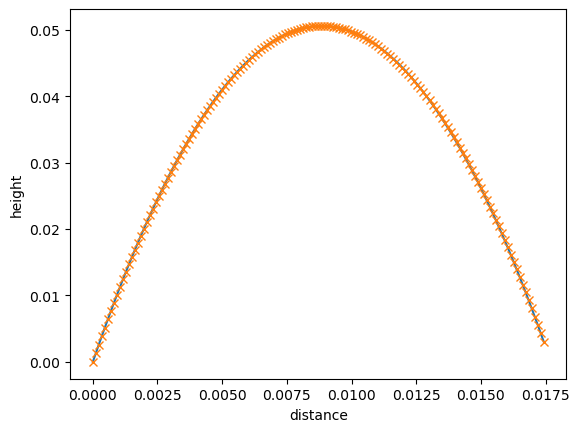

In [8]:
x, y = ystore[:,0], ystore[:,1]

xa, ya = vx0*tstore, vy0*tstore  - par.g*(tstore**2)/2.

plt.plot(xa, ya,'-',x,y,'x')
plt.ylabel('height')
plt.xlabel('distance')
#plt.ylim([0,40])
plt.show()

This looks pretty good! Now, go back to the model above, and run a different experiment with non zero drag. Make a single plot comparing the analytical solution, and numerical solutions for different drag levels.

# Damped Harmonic Oscillator Exercise

Now with trajectories understood, let's get back to the slightly more complicated oscillator example and build on your experiments in class. We will cover the isolated oscillator, and one that is driven by a periodic force, and explicitly account for damping.

The damped harmonic oscillator driven by a force $F$ is governed by the following equation
\begin{align}
\ddot{x} + 2 \zeta \omega \dot{x} + \omega^2  x = F(t),
\end{align}

where $x$ is the displacement, $\dot{x}$ is the velocity, $c\dot{x}$ a resisting force, $\ddot{x}$ is the acceleration, $\omega=\sqrt{\frac{k}{m}}$ is the angular frequency of the oscillator, and $\zeta=\frac{c}{2\sqrt{mk}}$ is the damping ratio. $F(t)$ is an external excitation or driving force, with spring stiffness $k$ and mass $m$. This is a more complicated, but also more complete, version of the model for oscillating sptring that we were considering in the last exercise, where we wrote
$m \ddot{x} + k x=0$. After adding the resistance, we get $m\ddot{x} + c \dot{x} +kx=0$, which we can rewrite as above. Verify this is the case.

We can define $y=\dot{x}$ so that the ODE equations to be solved are
1. $\dot{x} = y$, and 
2. $\dot{y} = F(t)-2\zeta\omega y -\omega^2x$.

For the force, we will also assume that $F(t) = F_m \sin(\omega_d t)$ with some driving frequency, $\omega_d$.

The tutorial contains functions that use three numerial methods - Euler, Midpoint and Runge-Kutta - and Scipy integrate ODE solver to solve the system. 

Five exercises are given to help you explore the charateristics of the sysetm.
1. simple harmonic oscillator;
2. underdamped harmonic oscillator;
3. critically damped harmonic oscillator;
4. overdamped harmonic oscillator;
5. harmonic oscillator driven by sinusoidal external excitation force;

## Solving the harmonic oscillator problem with ODEs


In [9]:
#%pip install -q ipywidgets matplotlib numpy scipy pandas 
#install packages used by this tutorial.
import numpy  as np
import pandas as pd
import ode    as odeLib        # our self-defined ODE routines in ode.py.
import matplotlib.pyplot as plt
from dataclasses import dataclass,astuple,asdict # for C-like structure
from   scipy                import integrate
from   ipywidgets           import *
from   IPython.display      import display

In [10]:
#
# define problem
#
# we now use a classs to collect all parameter for the ODE function
@dataclass
class parameters:                 # parameters for functions, default values
    zeta   :float  = 0
    omega  :float = 2.*np.pi*1.0
    Fm     :float  = 0
    omegad :float = omega
    ndim   :int  = 2
    
# 
# define functions for ODE solvers, need to be in f(t,x,par) format
#
# damped harmonic oscillator, dx/dt for dotx and x.


def f0(t,x,par):                  # dx/dt      = y
    return x[1]

def f1(t,x,par):                  
    # If with driven sinusoidal force, d^2 x/ dt^2 = dy/dt = f - 2*zeta*omega*dotx - omega^2*x + Fm*sin(omegad*t).
   
    return par.Fm*np.sin(par.omegad*t) -2.*par.zeta*par.omega*x[1] - par.omega**2*x[0] 

def ode_solver(xinit, time, method, par):
    # method supports three options
    # - 'euler'
    # - 'midpoint'
    # - 'runge_kutta'
    
    nstep = len(time)
    xout  = np.empty((nstep,par.ndim))
    
    hs    = time[1] - time[0] # determine solution step
    
    # important! here, we need to make a copy, we do not want to override anything in xinit, EVER
    # this is nicer but did not work with the interactive code
    #xtmp = xinit.copy()
    xtmp = np.empty(np.shape(xinit))
    for i in range(par.ndim):
        xtmp[i] = xinit[i]
    
    f     = [f0, f1]
    for i, t in enumerate(time):
        xout[i][:] = xtmp
        if method  == 'euler':
            xtmp   = odeLib.euler(t,xtmp,f,par.ndim,hs,par)
        elif method == 'midpoint':
            xtmp   = odeLib.midpoint(t,xtmp,f,par.ndim,hs,par)
        elif method == 'runge_kutta':
            xtmp   = odeLib.runge_kutta(t,xtmp,f,par.ndim,hs,par)
    return xout

### Black Box Approach

Python provides many tools, including the solution of ODEs for which Scipy has a number of methods. Solve the ODE system with the black box solver in Scipy integrate. 

In [11]:
#
# we need to redefine the call for argument lists
#
def dxdt(x, t, zeta,omega,Fm,omegad,ndim): # swap order for scipy and use a tupel of arguments
    f0 = x[1]
    f1 = Fm*np.sin(omegad*t) -2.*zeta*omega*x[1] - omega**2*x[0] 
    return [f0, f1]

def ode_solver_scipy(xInit,t, par):
    #print(astuple(par))
    # this is ugly, but we cannot pass a class??!
    sol     = integrate.odeint(dxdt, xInit, t, astuple(par), rtol=1e-8)
    #print(np.shape(sol))
    return sol


### General driver routine
This is a routine we will reuse for plotting and doing numerical experiments.

In [21]:
def driver(zeta = 0, omega = 1.*np.pi, Fm = 0, omegad = 2.*np.pi, xInit0 = [0, 0.], 
           method = 'euler', plot_feature=['k',2], tmax = 10, nsteps = 100, plabel = None):
    
    err = False
    
    # method: currently support four - 'euler', 'midpoint', 'runge_kutta', 'scipy'.
    # plot_feature: first param - line color; second param - line thickness.
    
    t      = np.linspace(0., tmax, nsteps)
    
    # set constants for the system
    par        = parameters()
    par.zeta   = zeta
    par.omega =  omega
    par.Fm     = Fm
    par.omegad = omegad
    
    if   ((method == 'euler')or(method=='midpoint')or(method=="runge_kutta")):
        x    = ode_solver(xInit0,t, method, par)
    elif method == 'scipy':
        x    = ode_solver_scipy(xInit0,t, par) 
    else:
        print('error, method', method, ' not defined')
        return False,0
    lt=int(nsteps*0.8)
    maxA       = np.max(abs(x[lt:nsteps,0]))
    
    if(plabel):
        plot_label = plabel
    else:
        #plot_label='omegad = '+str(omegad)
        plot_label=method
    plt.plot(t, x[:,0], plot_feature[0], label=plot_label, linewidth=plot_feature[1])
    plt.grid()
    #plt.ylim(-1., 1.)
    plt.xlabel("time, $t$")
    plt.ylabel("displacement, $x$")
    plt.legend()
    
    err = True
    return t,x,err, maxA

## Exercise 1 - Numerical solutions for the harmonic oscillator. 

This example has no driving force, and no damping, but compares the different numerical solution methods.

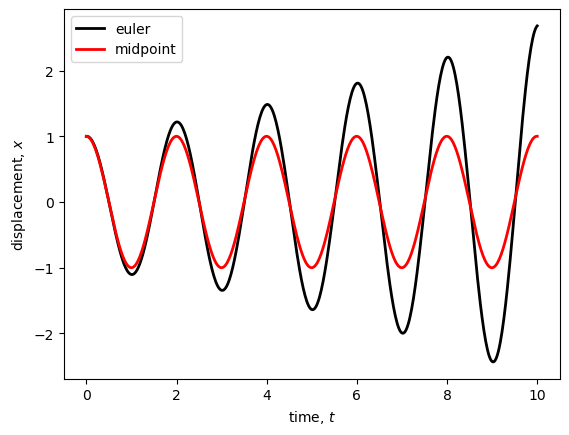

In [22]:
fig    = plt.figure()
omega  = 1*np.pi;
zeta=0;
omegad=omega;F=0

xinit= [1.,0.]

t, x,err, maxA = driver(zeta, omega,F,omegad,xinit, method = 'euler',    plot_feature = ['k',2],nsteps=500)
t, x,err, maxA = driver(zeta, omega,F,omegad,xinit, method = 'midpoint', plot_feature = ['r-',2],nsteps=500)



Comment on the difference in solution, and verify the results from your experiments. Can you use this setup, or modifications thereof to approximate your experimental results?

## Exercise 2 - Damped harmonic oscillator. 

Now introduce some damping, and compare our Runge Kutta method with the scipy black box solver, for example.

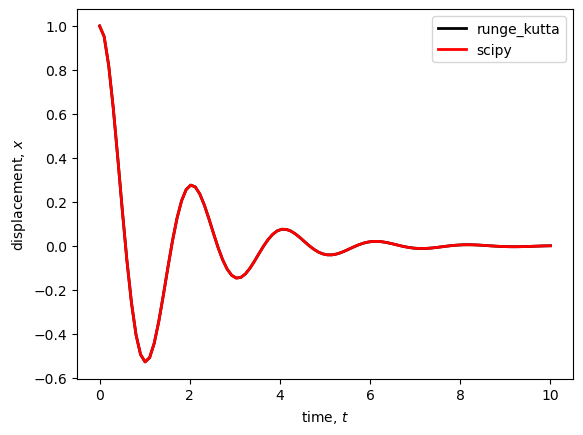

In [14]:
fig    = plt.figure()
zeta=0.2
t, x,err, maxA = driver(zeta, omega,F,omegad,xinit, method = 'runge_kutta',    plot_feature = ['k',2])
t, xd,err, maxA = driver(zeta, omega,F,omegad,xinit, method = 'scipy', plot_feature = ['r-',2])


How does our method, which uses a constant timestep, determine the time step? How much can you reduce the timestep to still broadly match the scipy prediction? How close are the scipy predictions to our RK approach?

## Exercise 3 - The critically damped harmonic oscillator

Now that we know our methods work, let us continue with the scipy implementation and focus on the physics, and explore the *critically damped harmonic oscillator*. Explore different damping values, between 0.1, 0.5, 1, and 1.5.


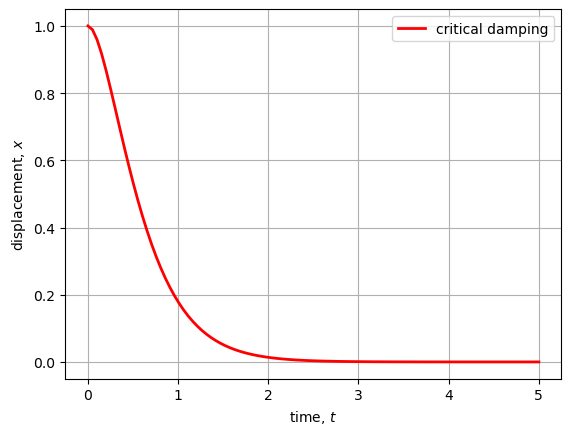

In [15]:
fig = plt.figure()

zeta=1
t, xcd,err, maxA = driver(zeta, omega,F,omegad,xinit, method = 'scipy', plot_feature = ['r-',2],tmax=5,plabel="critical damping")


What happens for unity damping, $\zeta = 1$? Why is this called the critcally damped oscillator?

The fact that $\zeta=1$ means something special motivates the use of $\zeta$, a rescaled damping version of $c$, in retrospect.

## Exercise 4  Overdamped harmonic oscillator. 

Let us increase the damping furhter, and see what happens.

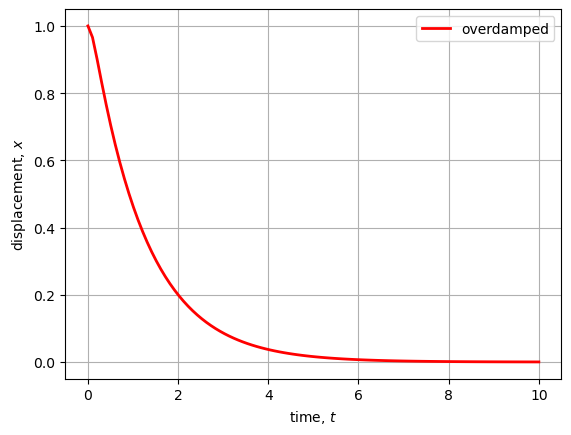

In [16]:
fig = plt.figure()
zeta=2
t, xod,err, maxA = driver(zeta, omega,F,omegad,xinit, method = 'scipy', plot_feature = ['r-',2],tmax=10,plabel="overdamped")

Comment on the behavior, including in comparison to the critically damped case.

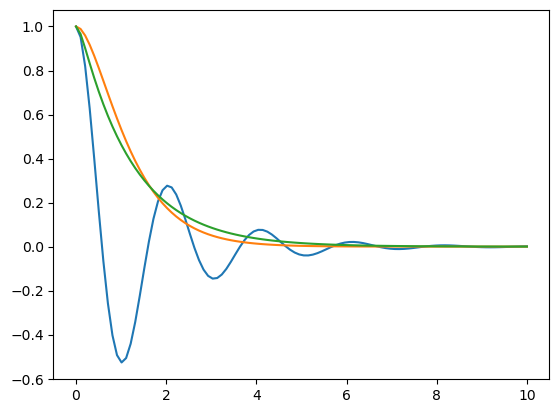

In [17]:
plt.plot(t,xd[:,0],t,xcd[:,0],t,xod[:,0])

## Exercise 5 - Driven harmonic oscillator.

Switch on the driving force and experiment. 

Here are a few scenarios to explore. <br>
What happens to the response frequency if you change the driving amplitudes? <br>
What happens to the peak reponse amplitudes if you change the driving frequencies or the oscillator frequency? <br>

(array([0.00000000e+00, 1.98235702e-02, 3.96471404e-02, ...,
        1.99960353e+02, 1.99980176e+02, 2.00000000e+02]),
 array([[ 0.00000000e+00,  0.00000000e+00],
        [ 1.94173944e-06,  2.94503223e-04],
        [ 1.55557660e-05,  1.17685924e-03],
        ...,
        [ 7.93680466e-01, -4.50788433e-02],
        [ 7.92436104e-01, -8.04555718e-02],
        [ 7.90491102e-01, -1.15761160e-01]]),
 True,
 0.7945492642972121)

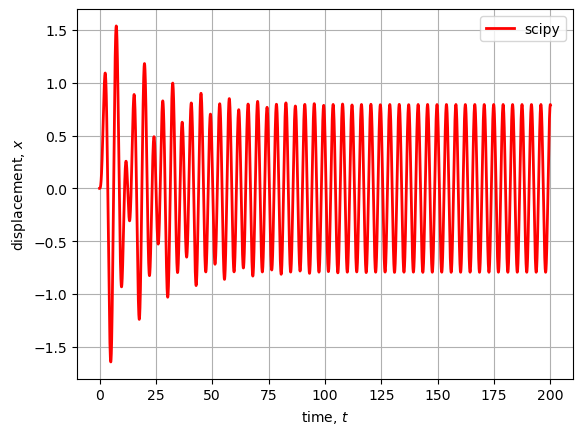

In [23]:
zeta = 0.05;
F=1;omega=1;

trange=200
omegad=1.5
tplot = np.linspace(0,trange,num=1000);yd=F*np.sin(omegad*tplot); 
#plt.plot(tplot,yd,'m-',label="F")
driver(zeta, omega,F,omegad,method = 'scipy', plot_feature = ['r-',2],nsteps=10090,tmax=trange)

#driver(zeta, omega,F,  1, method = 'scipy', plot_feature = ['g-',2],plabel="wd = 1",nsteps=1000,tmax=trange)
#driver(zeta, omega,F,  2, method = 'scipy', plot_feature = ['b-',2],plabel="wd = 2",nsteps=1000,tmax=trange)


Try different $\omega$, $\omega_d$ and $\zeta$ values. Experiment with different ways of plotting the results. Figure out how to extract the long term behavior, and how you might read off the long term amplitude response.

# Interactive plot
The following cell block provides an interactive plot for wide ranges of parameters. (NOTE: to disable auto-scrolling of the results, click the left bar of the figure cell or right-click the figure cell to choose 'disable auto-scrolling outputs'.)

In [25]:
    
# def driver(zeta = 0, omega = 2.*np.pi, Fm = 0, omegad = 2.*np.pi, xInit0 = [1., 0.], 
#           method = 'euler', plot_feature=['k',2], tmax = 10, nsteps = 100, plabel = None):

w = interactive(driver, 
                zeta   = (0., .3, 0.01), 
                omega  = fixed(1),
                Fm     = fixed(1.),
                omegad = (0.001, 5., 0.01),
                method = fixed('scipy'), 
                xInit0 = fixed([1,0]),
                plot_feature = fixed(['b-',2]),
                tmax = fixed(75),
                nsteps = fixed(500000),
                plabel = fixed(None)
               )
display(w)

interactive(children=(FloatSlider(value=0.0, description='zeta', max=0.3, step=0.01), FloatSlider(value=5.0, d…

This is simply meant as a more convenient way to conduct the numerical experiments you are meant to conduct next.

## Response experiment exercise

With those tools in hand, conduct a series of experiments that document the steady-state, i.e. long term, reponse of the driven oscillator amplitude for a constant, non zero, driving force, constant oscillator frequency, but variable driving frequency and damping. 

For this, you can either use the interactive tool with the sliders, or run the numerical example before then where you have to type in the parameters.

Start by choosing the damping to be $\zeta = 0.05$. Try a range of different $\omega_d$ and write down a table of response amplitude in terms of range of maximum and minimum displacement for different $\omega_d$ values. Plot those amplitudes as a function of $\omega_d$.

Repeat the experiment for $\zeta = 0.025$ and $\zeta=0$. Comment.

What shape do the curves have? What $\omega_d$ gives the largest response? How does that value relate to $\omega$?
